# Richards equation

In this tutorial we present how to solve a Richards equation with [PyGeoN](https://github.com/compgeo-mox/pygeon).  The unkwons are the velocity $q$ and the pressure $p$.

Let $\Omega=(0,2)\times(0,3)$ with boundary $\partial \Omega$ and outward unit normal ${\nu}$. Given 
$k$ the matrix permeability, we want to solve the following problem: find $({q}, h)$ such that
$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
K^{-1}(h) {q} + \nabla h = -\nabla z\\
\partial_t \theta (\psi) + \nabla \cdot {q} = 0
\end{array}
&\text{in } \Omega \times (0,T)
\end{array}
\right.
$$
with boundary conditions:

$$
\psi(t,x,z)=
\left\{
\begin{array}{ll}
\begin{array}{l} 
-2+2.2 \frac{t}{\Delta t_D}, \text{ on } \Gamma_{D_1}, t\leq\Delta t_D\\
0.2, \text{ on } \Gamma_{D_1}, t>\Delta t_D\\
1-z, \text{ on } \Gamma_{D_2}
\end{array}
\end{array}
\right., \qquad \nu \cdot q = 0 \text{ on } \Gamma_N \qquad \psi(0,x,z) = 1-z \text{ on } \Omega$$
and
$$
\Gamma_{D_1} = \left\{ (x,z) \in \partial \Omega \:|\: x \in [0,1] \wedge z=3  \right\},\\
\Gamma_{D_2} = \left\{ (x,z) \in \partial \Omega \:|\: x = 2 \wedge z \in [0,1]  \right\},\\
\Gamma_{D} = \Gamma_{D_1} \cup \Gamma_{D_2},\\
\Gamma_{N} = \partial \Omega \setminus \Gamma_D
$$

We present *step-by-step* how to create the grid, declare the problem data, and finally solve the problem.

### Import and parameters

In [1]:
import shutil
import os

import numpy as np
import scipy.sparse as sps
from scipy.sparse import linalg
import sympy as sp

import porepy as pp
import pygeon as pg

import time
from math import ceil, floor, log10, exp

import matplotlib.pyplot as plt

/opt/conda/lib/python3.11/site-packages/porepy/numerics/nonlinear/nonlinear_solvers.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


In [2]:
import sys
sys.path.insert(0, "/workspaces/richards/")

from richards.model_params import Model_Data
from richards.matrix_computer import Matrix_Computer

from richards.solver import Solver
from richards.solver_params import Solver_Data, Solver_Enum, Norm_Error

In [3]:
# Set the maximum number of iterations of the non-linear solver
K = 50

# L-scheme parameter
L = 3.501e-2

# Set the mesh refinment
N = 20

# Set the number of steps (excluding the initial condition)
num_steps = 27

# Simulation time length
T = num_steps/48

# Time switch conditions (for the boundary condition)
dt_D = 1/16

# Fluid density
rho = 1000

# Relative and absolute tolerances for the non-linear solver
abs_tol = 1e-5
rel_tol = 1e-5

# Domain tolerance
domain_tolerance = 1 / (10 * N)

# Output directory
output_directory = 'primal_multi_stage'

In [4]:
# Van Genuchten model parameters ( relative permeability model )
theta_s = 0.396
theta_r = 0.131

alpha = 0.423

n = 2.06
K_s = 4.96e-2

m = 1 - 1/n

In [5]:
# Time step
dt   = (T-0)/num_steps

In [6]:
model_data = Model_Data(theta_r=theta_r, theta_s=theta_s, alpha=alpha, n=n, K_s=K_s, T=T, num_steps=num_steps)

### Domain preparation

In [7]:
# Prepare the domain and its mesh
subdomain = pp.StructuredTriangleGrid([2*N, 3*N], [2,3])
pg.convert_from_pp(subdomain)

# Convert it to a mixed-dimensional grid
mdg = pg.as_mdg(subdomain)

In [8]:
key = "flow"

# Collection of boundary conditions
bc_value = []
bc_essential = []

# Initial pressure
initial_pressure = []

In [9]:
# Initial pressure function
def initial_pressure_func(x): 
    return 1

In [10]:
# Fake loop to extract the grid and its data (i.e. conductivity tensor)
subdomain, data = mdg.subdomains(return_data=True)[0]

# Gamma_D1 and Gamma_D2 boundary faces
gamma_d1 = np.logical_and(subdomain.nodes[0, :] > 0-domain_tolerance, np.logical_and(subdomain.nodes[0, :] < 1+domain_tolerance, subdomain.nodes[1, :] > 3-domain_tolerance))
gamma_d2 = np.logical_and(subdomain.nodes[0, :] > 2-domain_tolerance, np.logical_and(subdomain.nodes[1, :] > 0-domain_tolerance, subdomain.nodes[1, :] < 1+domain_tolerance))

gamma_d  = np.logical_or(gamma_d1, gamma_d2)
bc_essential = gamma_d

# Add a lambda function that generates for each time instant the (discretized) natural boundary conditions for the problem
bc_value = lambda t: np.array(gamma_d2, dtype=float) + np.array(gamma_d1, dtype=float) * min(6.2, 1 + 5.2 * t / dt_D)

### Method

A quick recap:
$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
K^{-1}(h) {q} + \nabla h = 0\\
\partial_t \theta (h) + \nabla \cdot {q} = 0
\end{array}
&\text{in } \Omega \times (0,T)
\end{array}
\right.
$$
becames, with the time discretization:

$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
K^{-1}(h^{n+1}_k) {q^{n+1}_{k+1}} + \nabla h^{n+1}_{k+1} = -\nabla z\\
\frac{\partial \theta(h_k^{n+1})}{\partial h} \frac{h_{k+1}^{n+1}}{\Delta t} + \nabla \cdot {q^{n+1}} = \frac{\partial \theta(h_k^{n+1})}{\partial h} \frac{h_{k}^{n+1}}{\Delta t} + \frac{\theta (h^{n}) - \theta (h^{n+1}_k)}{\Delta t} 
\end{array}
&\text{in } \Omega \times (0,T)
\end{array}
\right.
$$

In [11]:
if os.path.exists(output_directory):
    shutil.rmtree(output_directory)

In [12]:
# assemble initial solution
cp = Matrix_Computer(mdg)

In [13]:
solver_data = Solver_Data(mdg=mdg, initial_solution=cp.P1.interpolate(subdomain, initial_pressure_func), 
                          scheme=Solver_Enum.NEWTON, 
                          bc_essential=lambda t: bc_essential, bc_essential_value=bc_value,
                          eps_psi_rel=rel_tol, eps_psi_abs=abs_tol,
                          max_iterations_per_step=K, L_Scheme_value=L,
                          output_directory=output_directory, report_name='primal',
                          primal=True, integration_order=2, prepare_plots=True, 
                          shape_x=2*N+1, shape_y=3*N+1, norm_error=Norm_Error.EUCLIDIAN)

In [14]:
solver = Solver(model_data=model_data, solver_data=solver_data)

Csv_Exporter: A file with name primal_0_LSCHEME_richards_solver.csv is detected. I'll delete it
Csv_Exporter: A file with name primal_1_NEWTON_richards_solver.csv is detected. I'll delete it
Time 0.02083
LSCHEME


<lambdifygenerated-1>:2: RuntimeWarning: invalid value encountered in power
  return select([less(h, z),True], [0.265*(0.1699265174169*(-h + z)**2.06 + 1)**(-0.514563106796116) + 0.131,0.396], default=nan)
<lambdifygenerated-2>:2: RuntimeWarning: invalid value encountered in scalar power
  return select([less(h, z),True], [0.0496*(1 - (1 - 1.0*(0.1699265174169*(-h + z)**2.06 + 1)**(-1.0))**0.514563106796116)**2*(0.1699265174169*(-h + z)**2.06 + 1)**(-0.257281553398058),0.0496], default=nan)


Iteration #001, error L2 relative psi:    8.73752
Iteration #002, error L2 relative psi:    3.22723
Iteration #003, error L2 relative psi:    0.95874
Iteration #004, error L2 relative psi:    0.14461

NEWTON


<lambdifygenerated-3>:2: RuntimeWarning: invalid value encountered in power
  return select([less(h, z),True], [0.00446702828985547*(1 - (1 - 1.0*(0.1699265174169*(-h + z)**2.06 + 1)**(-1.0))**0.514563106796116)**2*(-h + z)**1.06*(0.1699265174169*(-h + z)**2.06 + 1)**(-1.25728155339806) + 0.0178681131594219*(1 - (1 - 1.0*(0.1699265174169*(-h + z)**2.06 + 1)**(-1.0))**0.514563106796116)*(1 - 1.0*(0.1699265174169*(-h + z)**2.06 + 1)**(-1.0))**(-0.485436893203884)*(-h + z)**1.06*(0.1699265174169*(-h + z)**2.06 + 1)**(-2.25728155339806),0], default=nan)
<lambdifygenerated-4>:2: RuntimeWarning: invalid value encountered in scalar power
  return select([less(h, z),True], [0.0477323587424072*(-h + z)**1.06*(0.1699265174169*(-h + z)**2.06 + 1)**(-1.51456310679612),0], default=nan)


Iteration #001, error L2 relative psi:    0.044475730
Iteration #002, error L2 relative psi:    0.000258138

Time 0.04167
LSCHEME
Iteration #001, error L2 relative psi:   13.42046
Iteration #002, error L2 relative psi:    5.05705
Iteration #003, error L2 relative psi:    1.81375
Iteration #004, error L2 relative psi:    0.48622
Iteration #005, error L2 relative psi:    0.17345

NEWTON
Iteration #001, error L2 relative psi:    0.063733691
Iteration #002, error L2 relative psi:    0.000561794

Time 0.0625
LSCHEME
Iteration #001, error L2 relative psi:   16.83284
Iteration #002, error L2 relative psi:    5.18387
Iteration #003, error L2 relative psi:    2.00091
Iteration #004, error L2 relative psi:    0.65381
Iteration #005, error L2 relative psi:    0.17955

NEWTON
Iteration #001, error L2 relative psi:    0.087742293
Iteration #002, error L2 relative psi:    0.000481496

Time 0.08333
LSCHEME
Iteration #001, error L2 relative psi:    7.36786
Iteration #002, error L2 relative psi:    2.8

/workspaces/richards/richards/plot_exporter.py:278: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(7, 10))


Time 0.4375
LSCHEME
Iteration #001, error L2 relative psi:    0.00000

NEWTON
Iteration #001, error L2 relative psi:    0.000000000

Time 0.45833
LSCHEME
Iteration #001, error L2 relative psi:    0.00000

NEWTON
Iteration #001, error L2 relative psi:    0.000000000

Time 0.47917
LSCHEME
Iteration #001, error L2 relative psi:    0.00000

NEWTON
Iteration #001, error L2 relative psi:    0.000000000

Time 0.5
LSCHEME
Iteration #001, error L2 relative psi:    0.00000

NEWTON
Iteration #001, error L2 relative psi:    0.000000000

Time 0.52083
LSCHEME
Iteration #001, error L2 relative psi:    0.00000

NEWTON
Iteration #001, error L2 relative psi:    0.000000000

Time 0.54167
LSCHEME
Iteration #001, error L2 relative psi:    0.00000

NEWTON
Iteration #001, error L2 relative psi:    0.000000000

Time 0.5625
LSCHEME
Iteration #001, error L2 relative psi:    0.00000

NEWTON
Iteration #001, error L2 relative psi:    0.000000000


1088.1773302555084


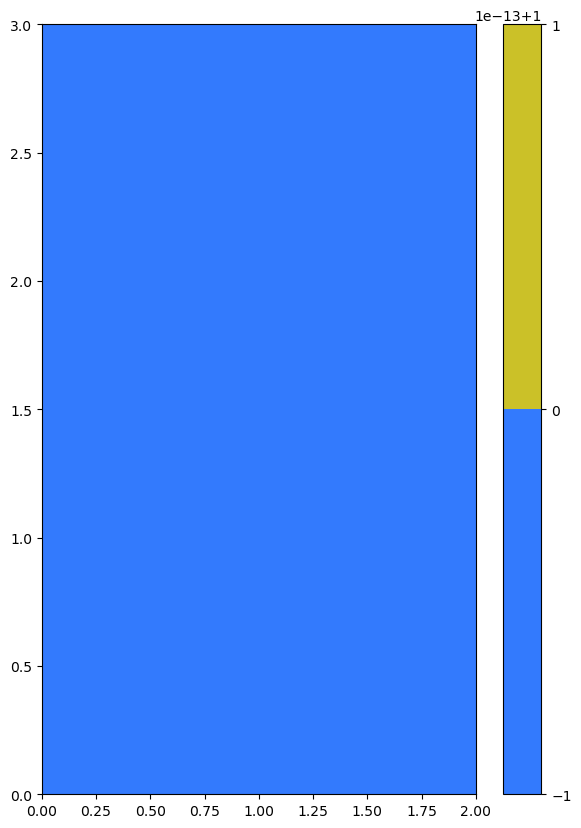

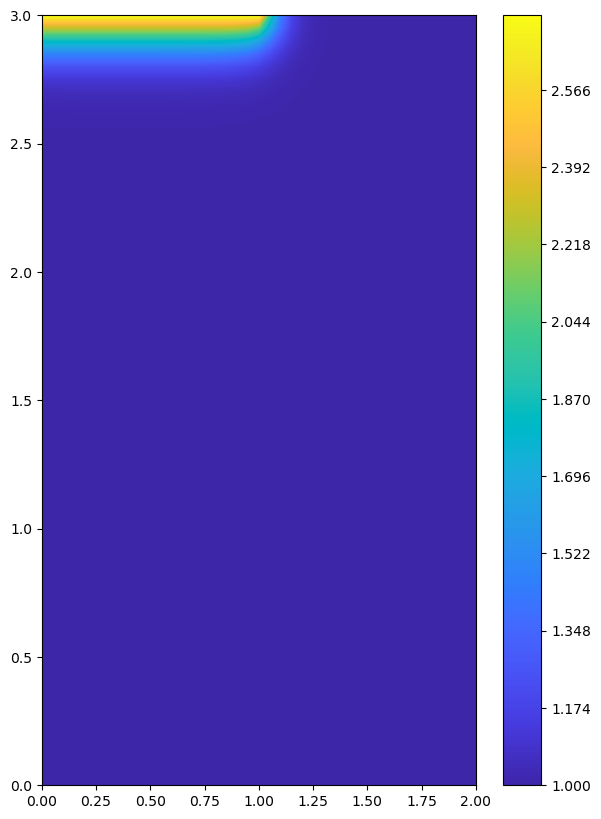

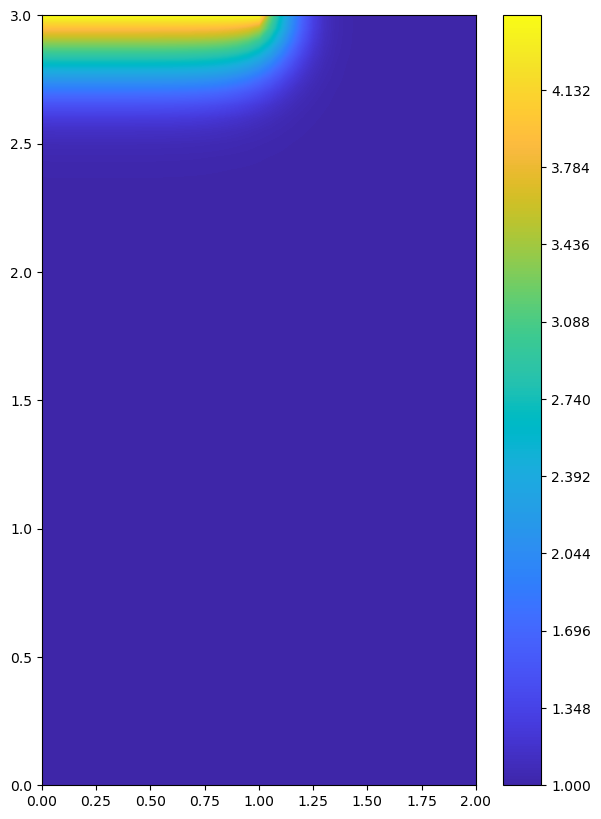

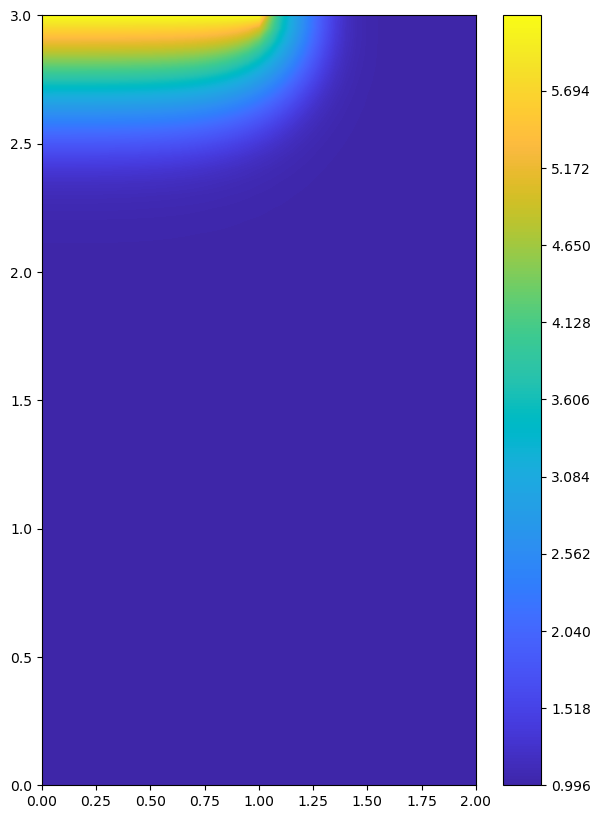

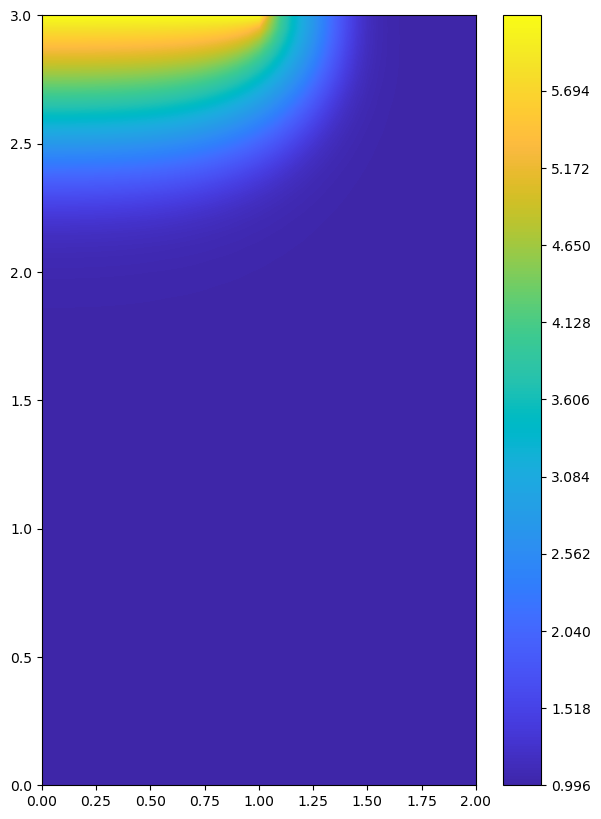

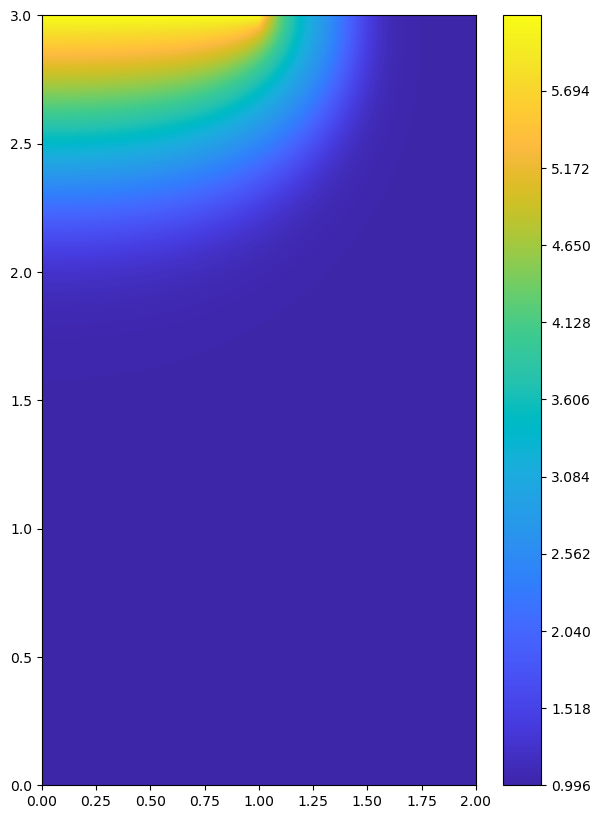

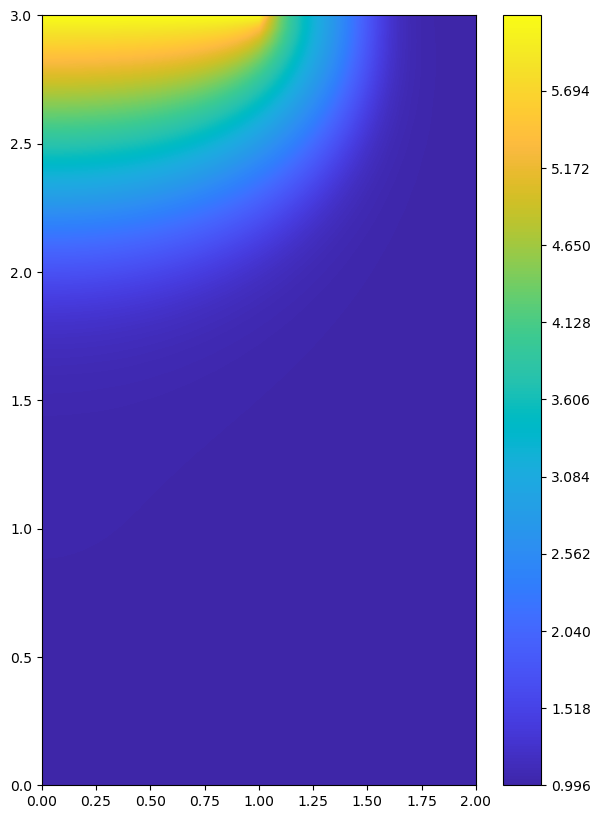

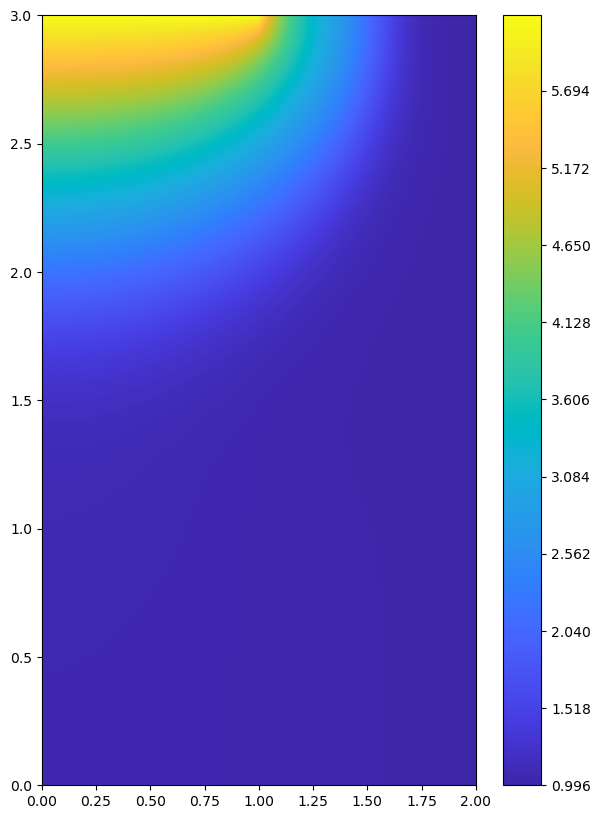

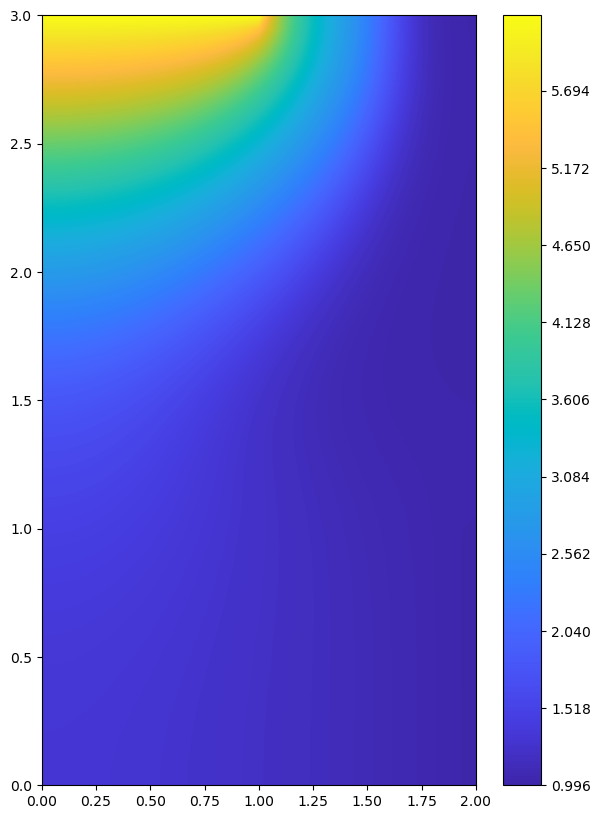

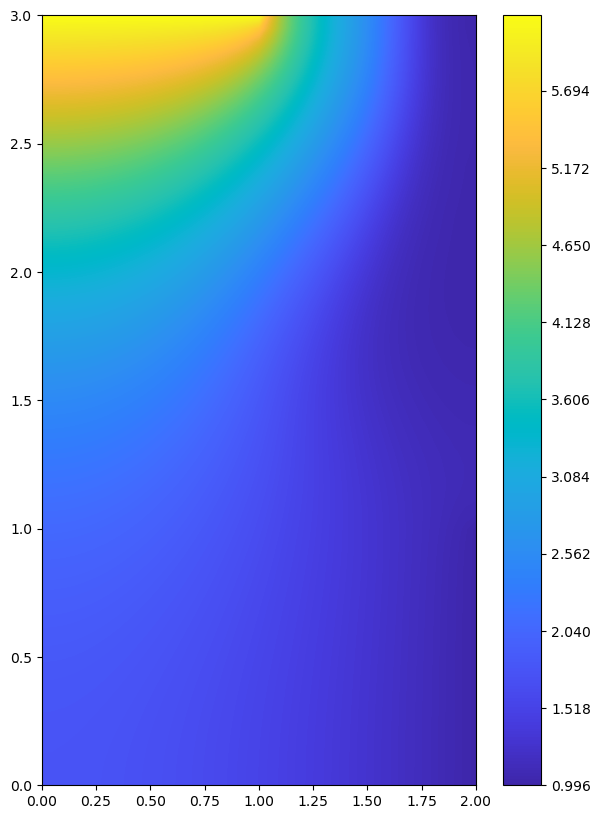

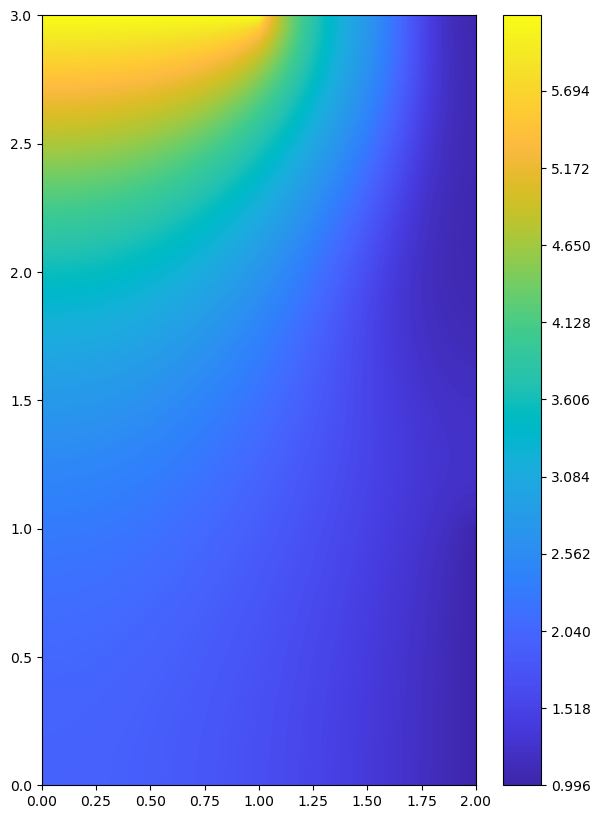

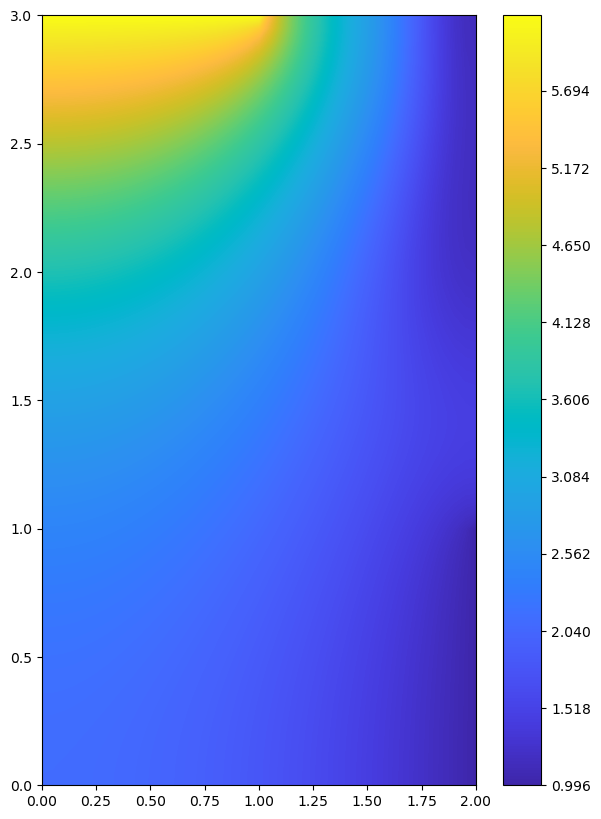

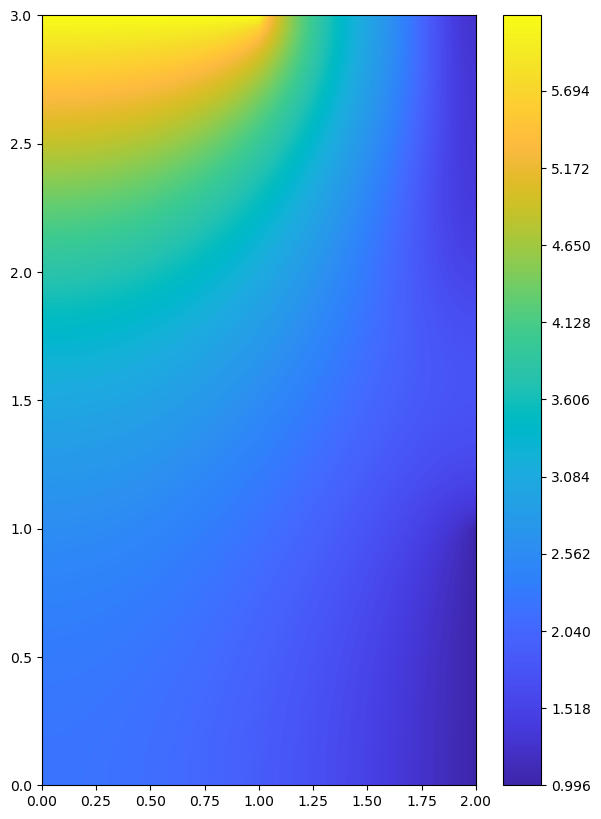

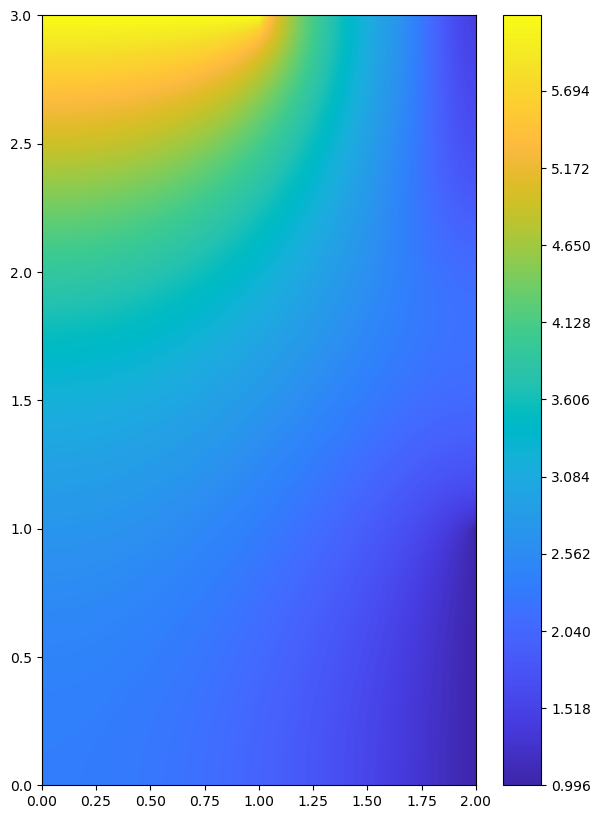

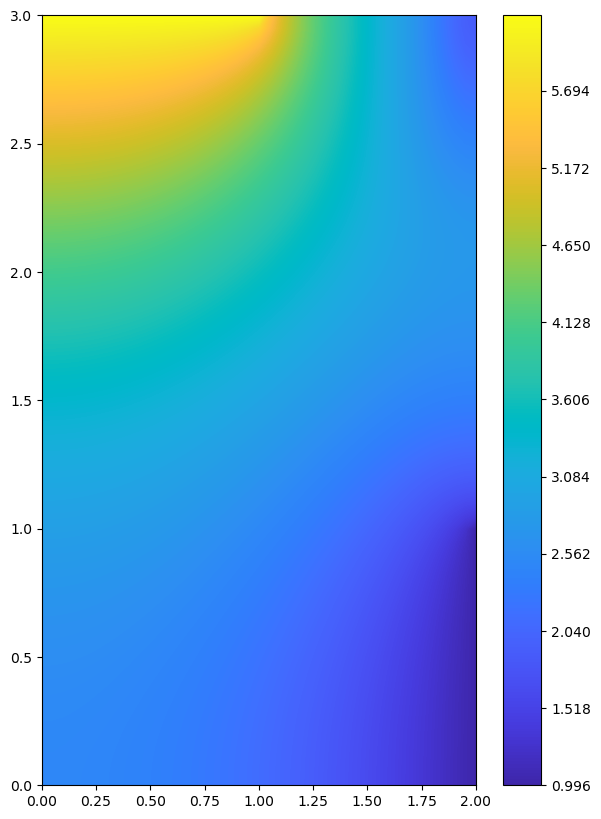

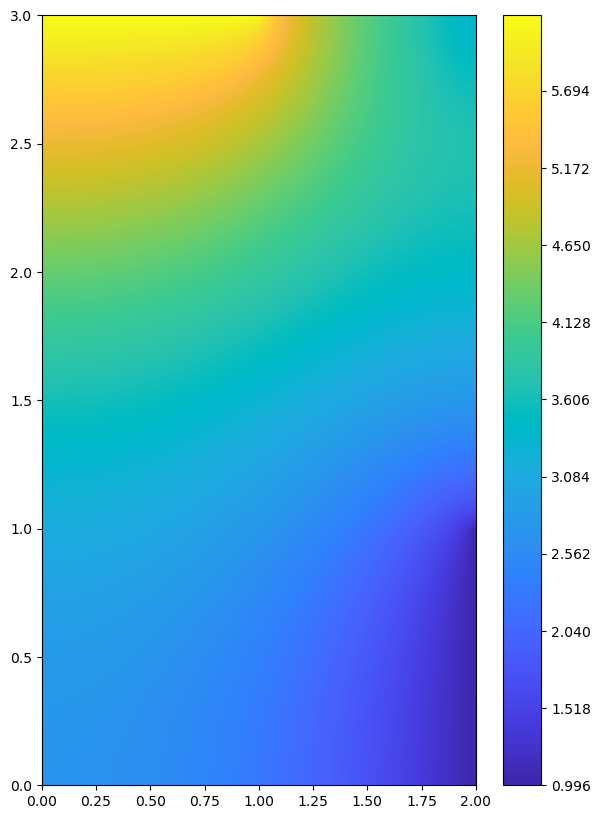

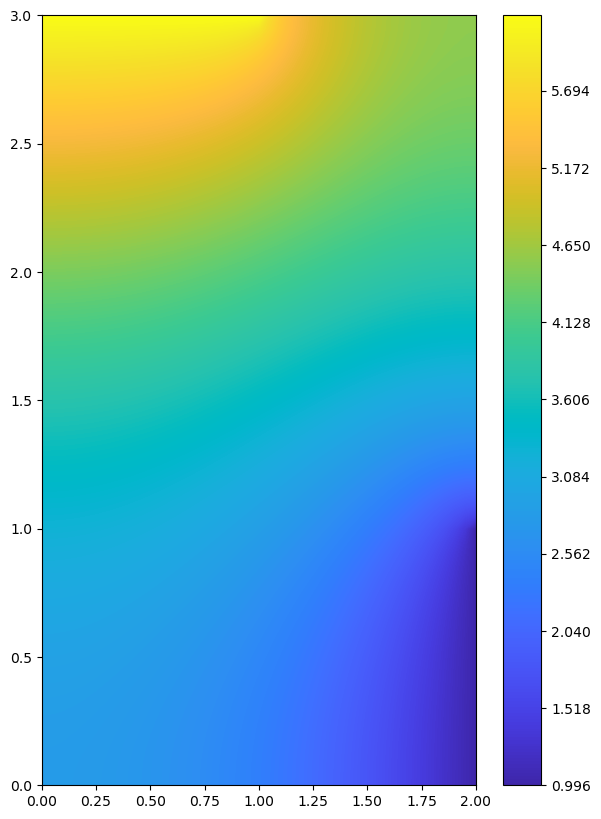

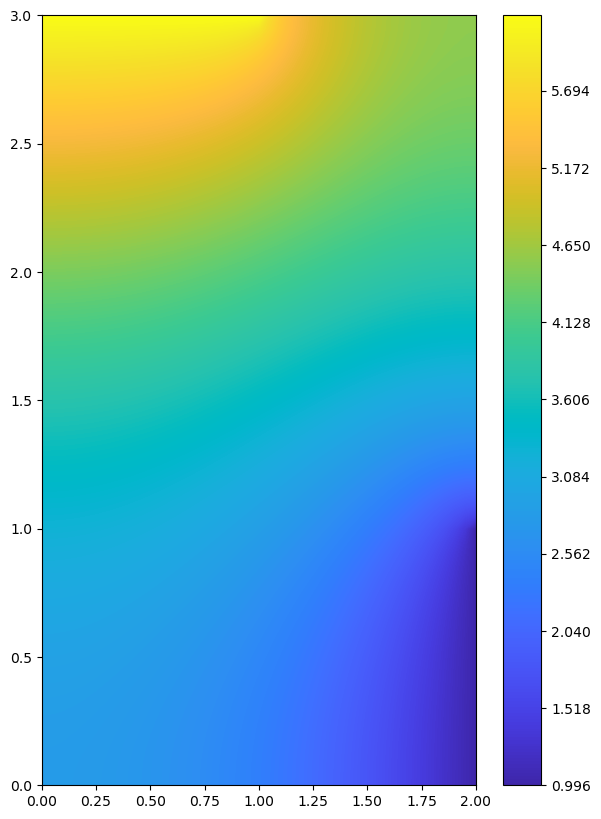

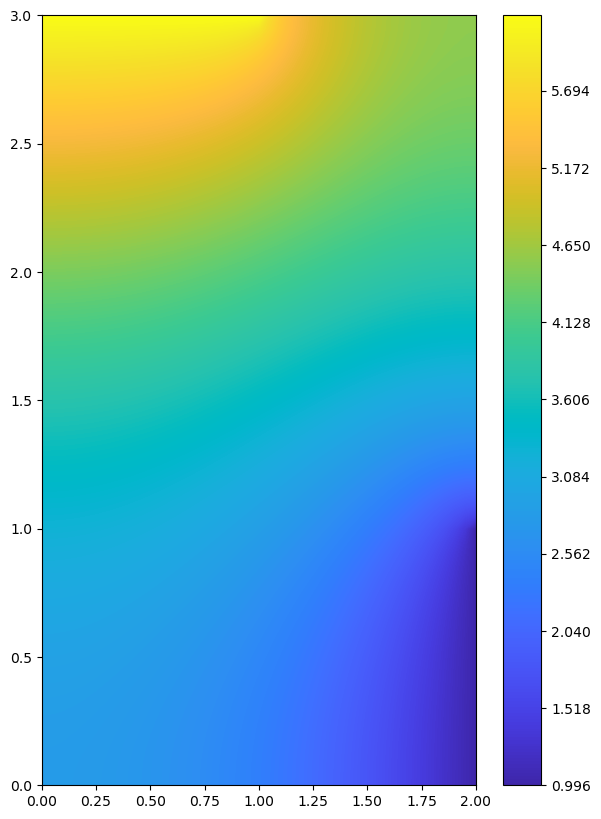

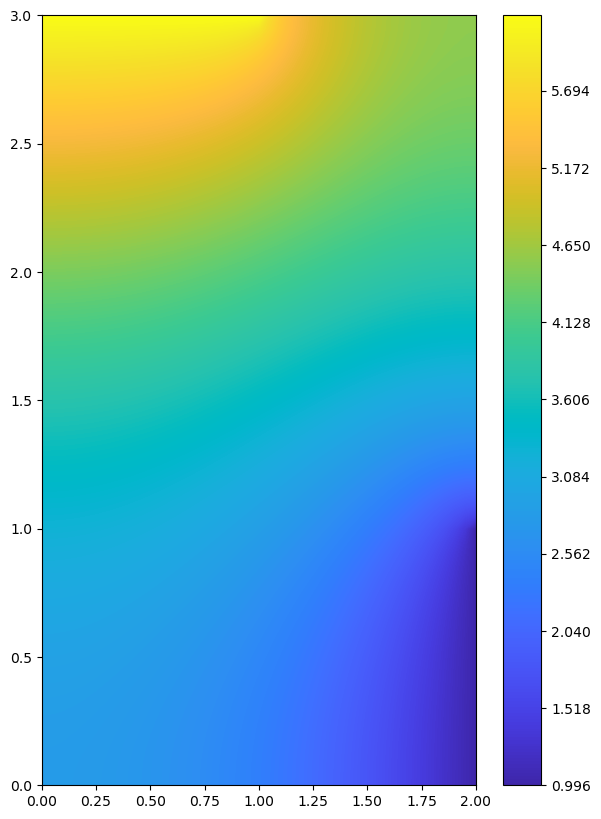

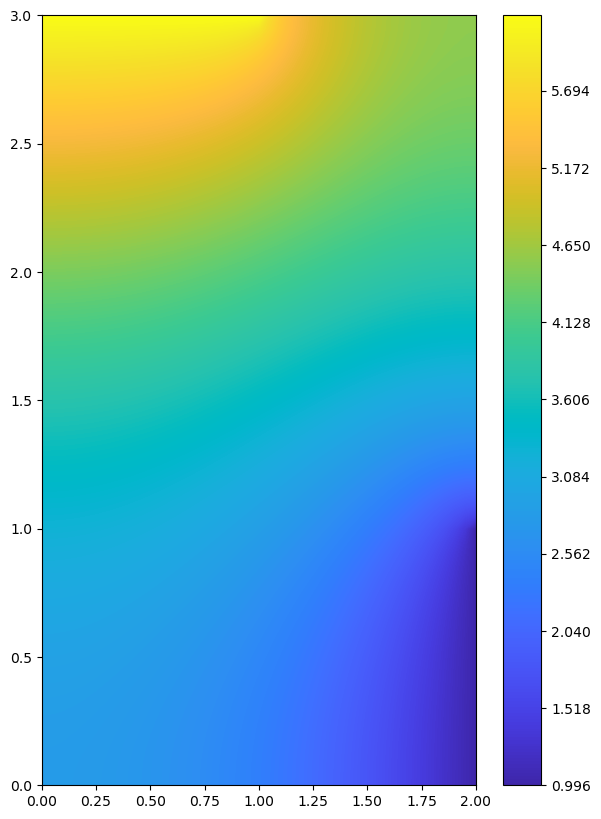

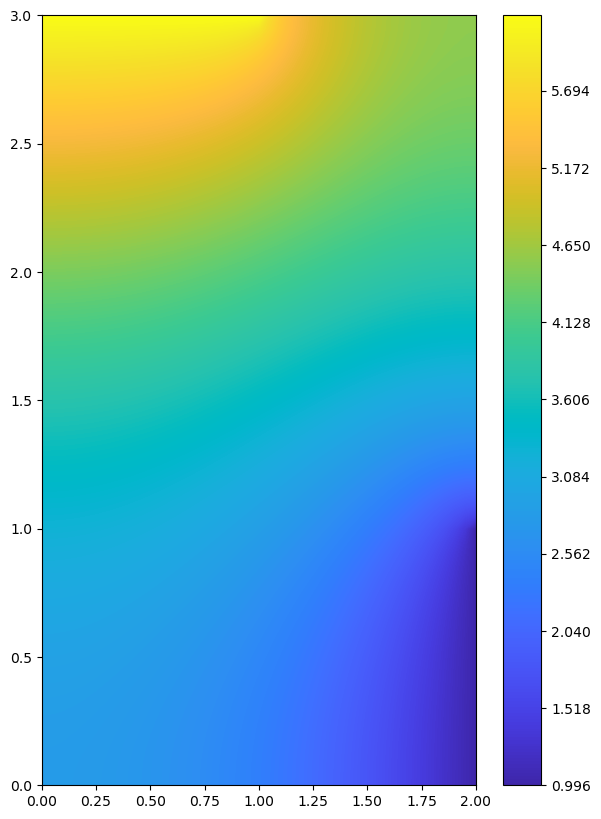

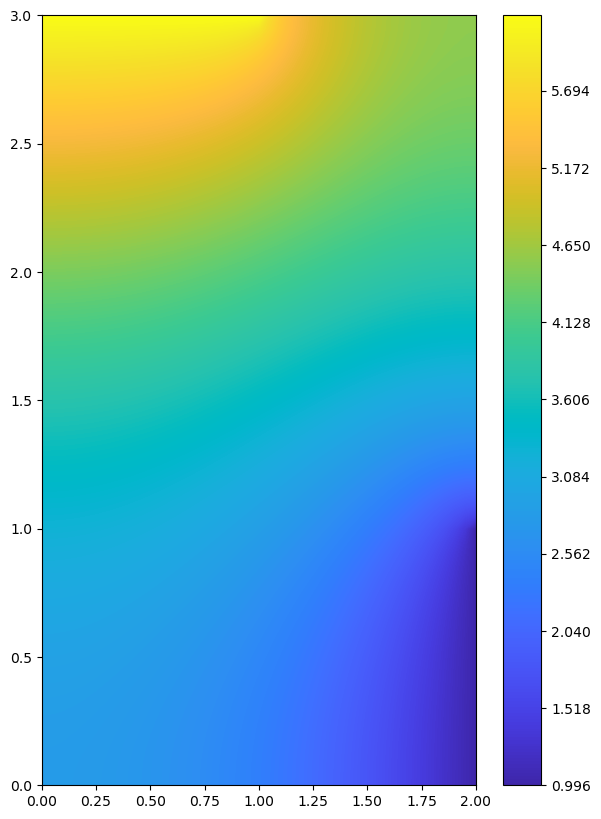

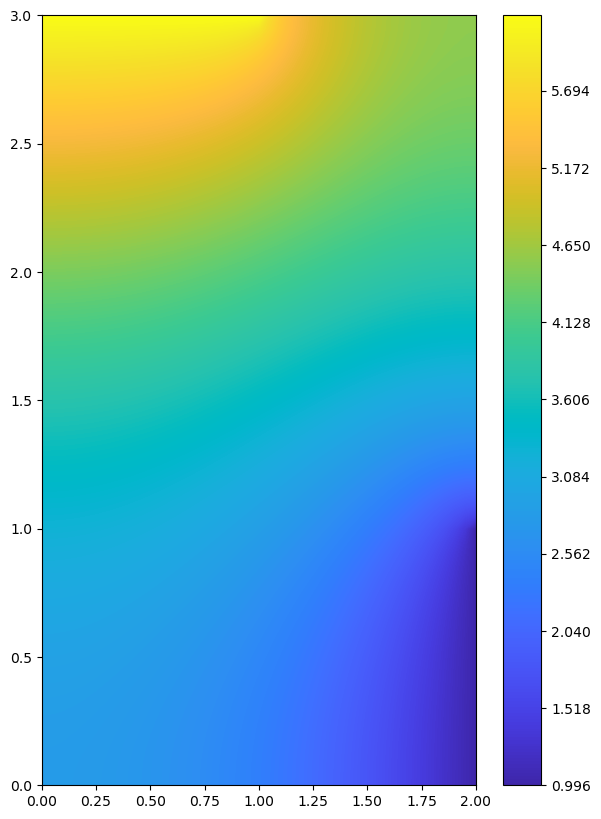

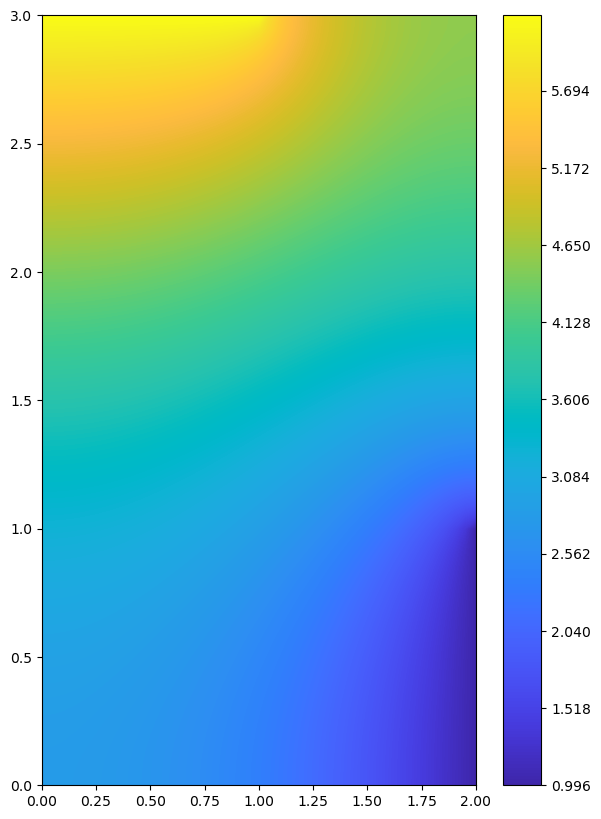

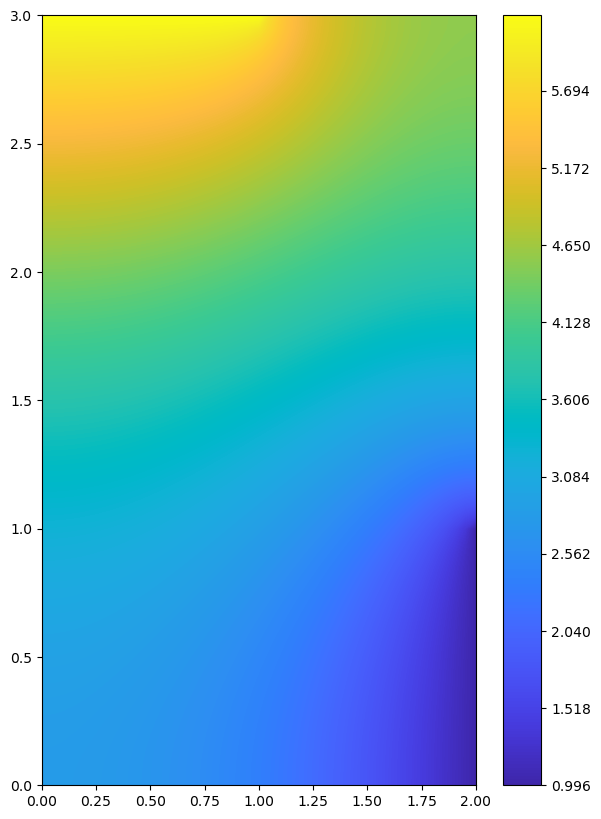

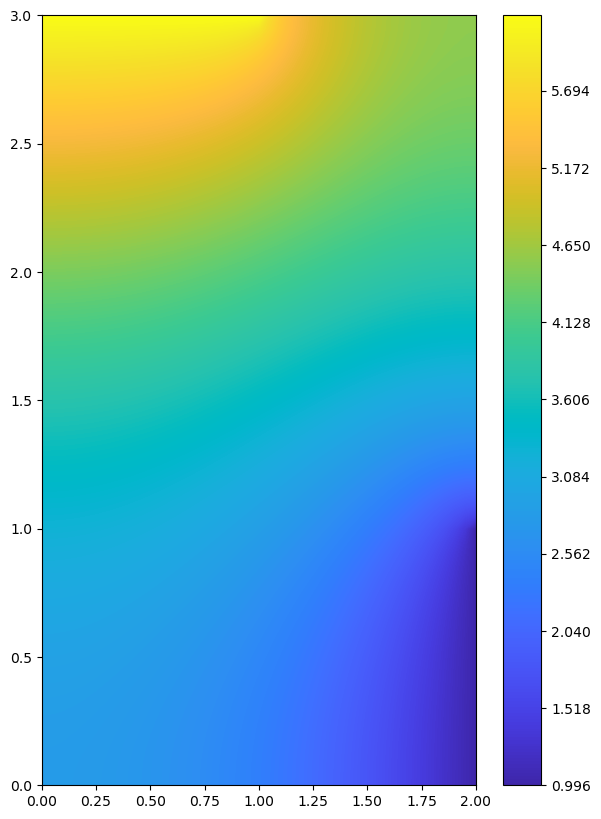

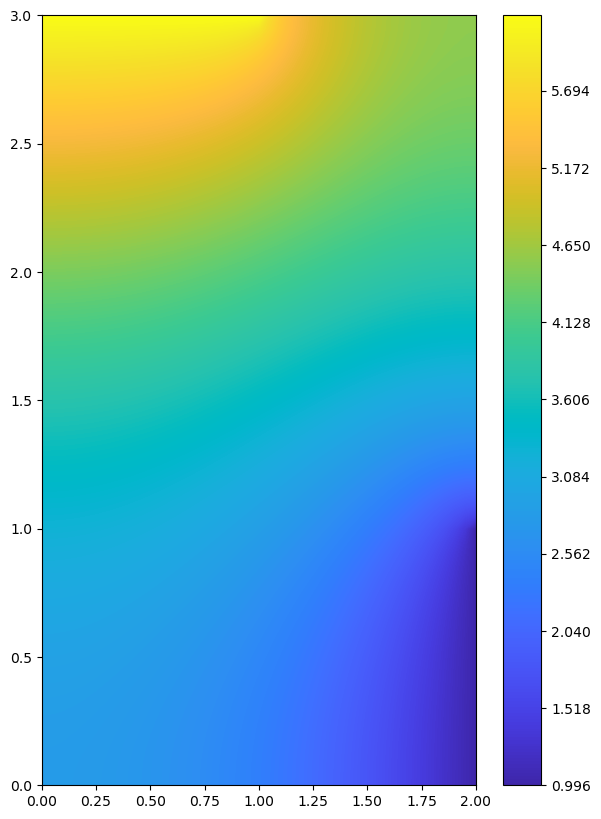

In [15]:
start = time.time()
solver.multistage_solver(schemes=[Solver_Enum.LSCHEME], iterations=[15], abs_tolerances=[0.2], rel_tolerances=[0])
end = time.time()

print('')
print(end - start)